In [77]:
import json
import matplotlib.pyplot as plt
import math
from time import sleep

In [78]:
with open("car_info.json", "r") as f:
    constants = json.load(f)

m = constants["car_mass"] \
    + constants["occupant_mass"] * constants["occupant_count"] \
    + (constants["rotational_inertia_front"]+constants["rotational_inertia_back"])/constants["wheel_radius"]**2
Cdrag = constants["drag_coefficient"]
Croll = constants["rolling_resistance_coefficient"]
g = constants["gravity"]
rho = constants["air_density"]
frontal_area = constants["frontal_area"]
motor_efficiency = constants["motor_efficiency"]
auxiliary = constants["auxiliary_power"]
regen_efficiency = constants["regen_efficiency"]
solar = 350
full_battery = constants["total_battery_energy"]

In [79]:
height = []
with open("HighwayCircuitHeights.json", "r") as f:  #with open("wr_heights.json", "r") as f:
    data = json.load(f)
    chunk_size = data[1]["distance"]-data[0]["distance"] # Chunk size is assumed constant throughout height data.
    num_chunks = len(data)
    target = full_battery*(data[-1]["distance"]/1000000)
    for chunk in data:
        height.append(chunk["height"])

grad = [math.atan((height[(i+1) % num_chunks]-height[(i-1) % num_chunks])/(2*chunk_size)) for i in range(len(height))]


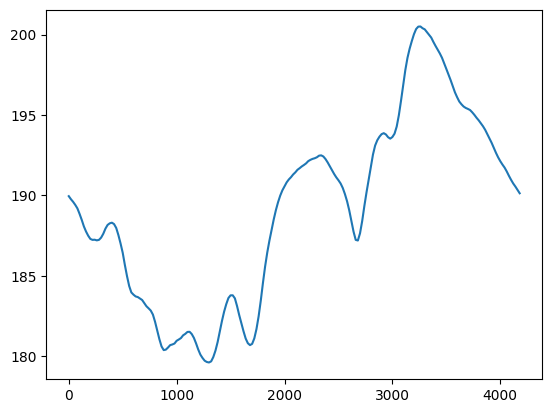

In [80]:
plt.plot([20*i for i in range(num_chunks)], height)

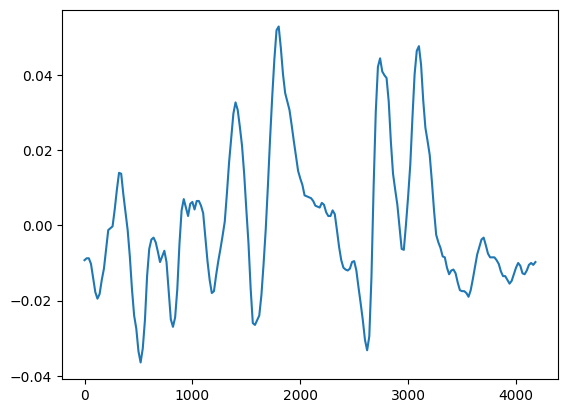

In [81]:
plt.plot([20*i for i in range(num_chunks)], grad)

Hyperparameters:

In [82]:
lamb = 0.1
lr = 1
init_v = 30

In [83]:
def accel_gen(v):
    return([v[i]*(v[(i+1) % num_chunks]-v[(i-1) % num_chunks]) / (2*chunk_size) for i in range(num_chunks)])

In [84]:
def Phi(v,theta): # Phi_i
    Aero = Cdrag * rho * frontal_area * v**3 / 2
    Roll = Croll * m * v * g * math.cos(theta)
    Grad = m * v * g * math.sin(theta) 
    return Aero + Roll + Grad

In [85]:
def del_Phi(v,theta): # dPhi_i/dv_i
    return 3/2 * Cdrag * rho * frontal_area * v**2 + Croll * m * g * math.cos(theta) + m * g * math.sin(theta) 

In [86]:
def P_star(v, a): # P* does not take into account max regen power production Rmax.
    Ps = [auxiliary - solar]*num_chunks
    for i in range(num_chunks):
        motor_power = m*v[i]*a[i] + Phi(v[i],grad[i])
        if motor_power >= 0:
            Ps[i] += motor_power/motor_efficiency
        else:
            Ps[i] += motor_power*regen_efficiency
    
    return Ps

In [87]:
def P_star_error(Ps, v):

    return (1-lamb)*(chunk_size/target*sum(Ps)-1)**2+lamb*sum([1/v[i] for i in range(num_chunks)])*(20/num_chunks)

In [88]:
def P_star_error_gradients(Ps, v, a):

    dP_dv = [0]*num_chunks # dP*(v_i,a_i)/dv_i
    dP_dv_offset = [0]*num_chunks # dP*(v_i,a_i)/dv_i+1
    Ps_sum = sum(Ps)

    for i in range(num_chunks):
        motor_power = m*v[i]*a[i] + Phi(v[i], grad[i])
        del_motor_power = m*2*a[i]+del_Phi(v[i], grad[i])
        if motor_power >= 0:
            dP_dv[i] = del_motor_power/motor_efficiency
            dP_dv_offset[i] = v[i]/(2*chunk_size*motor_efficiency)
        else:
            dP_dv[i] = del_motor_power*regen_efficiency
            dP_dv_offset[i] = v[i]*regen_efficiency/(2*chunk_size)
            
    error_grad = [0]*num_chunks

    for i in range(num_chunks):
        error_grad[i] = 2*(1-lamb)*(chunk_size/target)*(dP_dv[i] + dP_dv_offset[(i-1) % num_chunks] - dP_dv_offset[(i+1) % num_chunks])*(chunk_size/target*Ps_sum-1)-lamb/(v[i]**2)*(20/num_chunks)

    return error_grad

Core Gradient Descent Loop

151.82058719922222


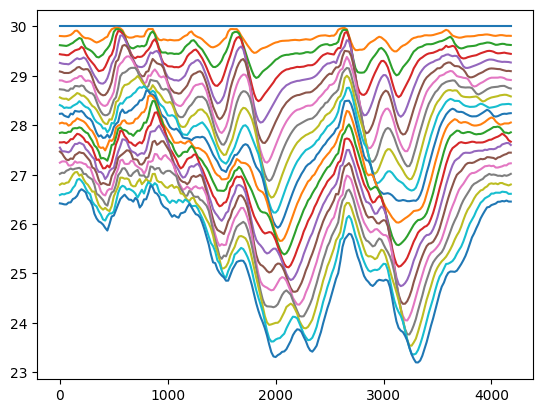

In [92]:
%matplotlib inline

v = [init_v]*num_chunks

loss_history = []
v_history = []
counter = 0

cc = 1000
best_error = 9999
best_v = v

while True:

    a = accel_gen(v)
    Ps = P_star(v, a)
    error = P_star_error(Ps, v)

    if counter % (cc//20) == 0: 
        plt.plot([20*i for i in range(num_chunks)], v)
        plt.show
        v_history.append(v)

    if error < best_error:
        best_error = error
        best_v = v

    loss_history.append(error)

    if (error-best_error) > best_error*2:
        break

    #
    if (error) > best_error:
        break
    #

    ### DELETEME
    if counter >= cc:
        print(error)
        break
    ###

    counter += 1

    error_grads = P_star_error_gradients(Ps, v, a)
    erg_sum = sum([abs(error_grad) for error_grad in error_grads])
    v = [abs(v[i]-lr*error_grads[i]/erg_sum) for i in range(num_chunks)]
    


20.144064520552842


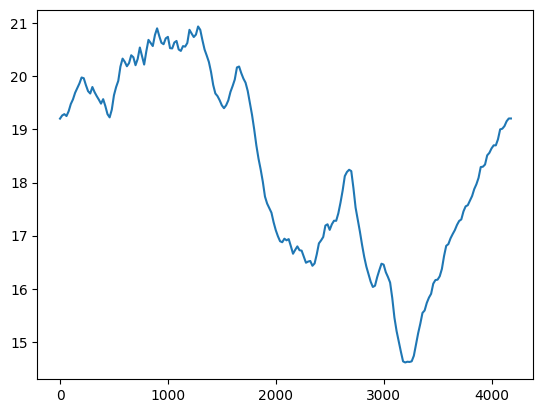

In [90]:
print(best_error)
plt.plot([20*i for i in range(num_chunks)], best_v)
plt.show()

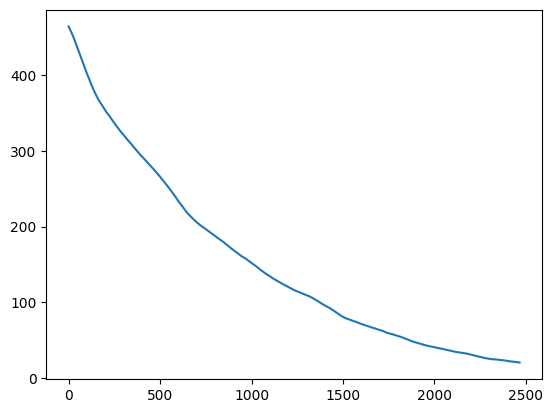

20.145901881212346


In [91]:
plt.plot(loss_history)
plt.show()

print(loss_history[-1])